In [2]:
import scipy.sparse as ss
import numpy as np

from networkx.generators.random_graphs import erdos_renyi_graph

# convenience class implementing the same interface as the random graph class
class UserDirectedGraph():
    def __init__(self, edges, nodes=None):
        self.edges = edges
        self.nodes = nodes if nodes is not None else (
            list(set(n for e in edges for n in e))
        )

def get_normalized_undirected_adjacency(g):
    """
        assume g is directed
    """
    src, dst = list(zip(*g.edges))
    V, E = len(g.nodes), len(g.edges)
    adj_sparse = ss.coo_matrix((np.ones(2*E), (src+dst, dst+src)))
    adj_dense = adj_sparse.todense()
    adj_dense_norm = adj_dense / adj_dense.sum(axis=1)
    return V, E, np.array(adj_dense_norm)


In [3]:
# define graph

g1 = UserDirectedGraph([(0, 2), (0, 1), (1, 2), (3, 4), (1, 3)])
print(g1.nodes)
print(g1.edges)

V, E, adj_dense_norm = get_normalized_undirected_adjacency(g1)
print("V=", V, "E=", E)
print("\nnormalized adj")
print(adj_dense_norm)

[0, 1, 2, 3, 4]
[(0, 2), (0, 1), (1, 2), (3, 4), (1, 3)]
V= 5 E= 5

normalized adj
[[0.         0.5        0.5        0.         0.        ]
 [0.33333333 0.         0.33333333 0.33333333 0.        ]
 [0.5        0.5        0.         0.         0.        ]
 [0.         0.5        0.         0.         0.5       ]
 [0.         0.         0.         1.         0.        ]]


In [4]:
N_STEPS = 10

# random state
rng = np.random.default_rng(seed=11111993)

color_init = rng.uniform(size=V); color_init

# this value doesn't change in this implementation, but it could, so call it ..._init.
confidence_init = rng.uniform(size=V); confidence_init
print("\ncolor init")
print(color_init)
print("\nconfidence init", confidence_init)

def steps(state, step_fn, n_steps, rng, log_every_n=5):
    """
    in:
        state (for now) shape (V,)
        step_fn: (adj_dense_norm, state, rng)
            e.g. `step_with_confidence`
    """
    out = [state]
    for i in range(n_steps):
        state = step_fn(adj_dense_norm, state, rng)
        if i % log_every_n == 0:
            print(f"step: {i}")
            print(state)
            
        out.append(state)
        
    return np.stack(out)

def sample_adjacency(adj_dense_norm):
    def _spl(row):
        return rng.multinomial(1, row)
    return np.apply_along_axis(_spl, 1, adj_dense_norm)

# accidentally cool name
def step_with_confidence(adj_dense_norm, state, confidence, rng):
    """
        adj_dense_norm: adjacency matrix, shape (V, V) with rows 
        normalized so that each row is a categorical distribution.
        
        state: (for now) shape (V,)
        
        confidence: shape (V,)
        
        rng: numpy random num. gen.
    """
    spl_adj = sample_adjacency(adj_dense_norm)
    spl_conf = rng.binomial(1, p=confidence)
    own_mask = np.multiply(spl_conf, state)
    neighbor = spl_adj @ state    
    neighbor_mask = np.multiply(neighbor, (1 - spl_conf)) 
    return own_mask + neighbor_mask

result = steps(
    color_init,
    lambda adj, st, rng: step_with_confidence(adj, st, confidence_init, rng),
    10,
    rng
)


color init
[0.05785952 0.32114978 0.87749512 0.33345169 0.99880353]

confidence init [0.81683423 0.82099299 0.45207527 0.5440367  0.5138801 ]
step: 0
[0.32114978 0.32114978 0.05785952 0.33345169 0.33345169]
step: 5
[0.32114978 0.32114978 0.32114978 0.32114978 0.33345169]


In [310]:
from scipy.stats import entropy

import pandas as pd
from collections import OrderedDict
def summarize_by_step(result):
    df = pd.DataFrame(result)
    out1 = df.agg(['count', 'nunique', 'mean', np.var], axis=1)
    extra_stats = OrderedDict(
        [
            ("entropy", lambda s: entropy(s.value_counts()))
        ]
    )
    out2 = df.agg(list(extra_stats.values()), axis=1)
    out2.columns = list(extra_stats.keys())
    return pd.concat([out1, out2], axis=1)

summary = summarize_by_step(result)

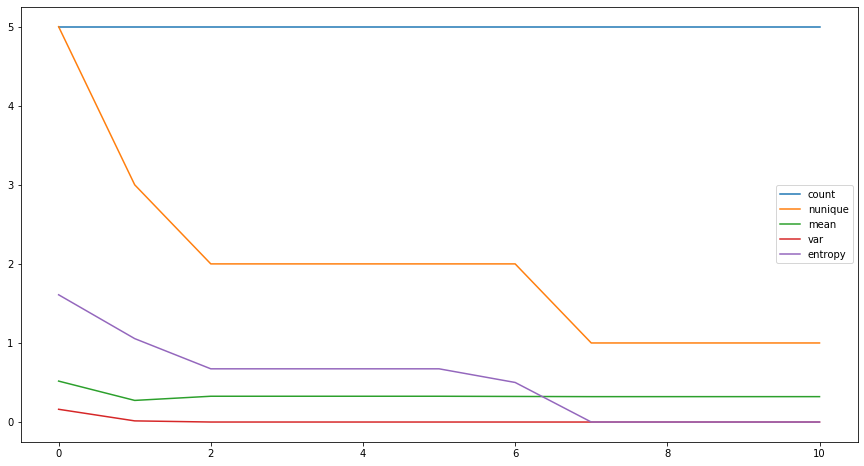

In [312]:
summary.plot.line(figsize=(15, 8))

In [332]:
g2 = erdos_renyi_graph(100, 0.5, 11111993)
print(g2.nodes)
print(g2.edges)

V, E, adj_dense_norm = get_normalized_undirected_adjacency(g2)
print("V=", V, "E=", E)
print("\nnormalized adj")
print(adj_dense_norm)

color_init = rng.uniform(size=V); color_init

# this value doesn't change in this implementation, but it could, so call it ..._init.
confidence_init = rng.uniform(size=V); confidence_init
print("\ncolor init")
print(color_init)
print("\nconfidence init", confidence_init)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[(0, 1), (0, 3), (0, 5), (0, 6), (0, 7), (0, 8), (0, 12), (0, 14), (0, 15), (0, 16), (0, 17), (0, 19), (0, 23), (0, 24), (0, 25), (0, 26), (0, 31), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 47), (0, 51), (0, 52), (0, 59), (0, 60), (0, 61), (0, 62), (0, 64), (0, 65), (0, 66), (0, 67), (0, 69), (0, 70), (0, 73), (0, 74), (0, 75), (0, 81), (0, 82), (0, 85), (0, 90), (0, 94), (0, 96), (0, 97), (0, 98), (1, 4), (1, 5), (1, 6), (1, 8), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 18), (1, 19), (1, 20), (1, 22), (1, 24), (1, 27), (1, 29), (1, 30), (1, 32), (1, 37), (1, 40), (1, 41), (1, 43), (1, 46

In [352]:
result = steps(
    color_init,
    lambda adj, st, rng: step_with_confidence(adj, st, confidence_init, rng),
    100,
    rng,
    log_every_n=50
)


step: 0
[8.79561355e-01 2.28146111e-01 1.47628166e-01 6.29842529e-01
 1.75521770e-02 7.00211727e-01 6.29842529e-01 1.30639941e-01
 2.24330127e-01 8.11312843e-01 7.45095451e-01 1.33988287e-01
 2.53604463e-01 5.66087748e-01 2.30987430e-01 3.00200428e-01
 6.54368637e-01 6.46958531e-01 6.69278779e-01 9.34553060e-01
 5.40332013e-01 5.55509946e-01 3.57796264e-01 5.29338606e-01
 5.75490460e-01 6.46909278e-01 3.51650115e-01 2.30987430e-01
 5.66087748e-01 8.60290403e-02 7.70144371e-01 1.30639941e-01
 1.85706782e-01 7.24321675e-01 2.53604463e-01 8.30665209e-01
 4.05694027e-01 1.85706782e-01 1.47628166e-01 2.78832583e-01
 4.18717292e-01 3.51650115e-01 9.29745576e-01 2.59690360e-01
 5.73699079e-01 4.83970204e-01 8.30665209e-01 9.60174338e-01
 1.68739383e-01 7.45095451e-01 7.74526186e-01 7.11448238e-01
 3.00200428e-01 4.35649780e-01 9.34553060e-01 9.31314388e-01
 2.53604463e-01 2.94369525e-01 4.13052832e-01 4.18717292e-01
 5.40332013e-01 6.46909278e-01 9.47323369e-01 9.47323369e-01
 8.79561355e-01 

In [361]:
result[-1,:]

array([0.43564978, 0.93848973, 0.93848973, 0.43564978, 0.43564978,
       0.93848973, 0.93848973, 0.43564978, 0.43564978, 0.93848973,
       0.43564978, 0.43564978, 0.40998088, 0.40998088, 0.43564978,
       0.43564978, 0.43564978, 0.43564978, 0.93848973, 0.43564978,
       0.43564978, 0.43564978, 0.43564978, 0.43564978, 0.43564978,
       0.43564978, 0.43564978, 0.43564978, 0.43564978, 0.93848973,
       0.43564978, 0.93848973, 0.43564978, 0.22433013, 0.43564978,
       0.43564978, 0.43564978, 0.93848973, 0.43564978, 0.40998088,
       0.43564978, 0.43564978, 0.43564978, 0.43564978, 0.40998088,
       0.43564978, 0.43564978, 0.43564978, 0.43564978, 0.93848973,
       0.43564978, 0.93848973, 0.43564978, 0.43564978, 0.93848973,
       0.40998088, 0.22433013, 0.93848973, 0.93848973, 0.43564978,
       0.93848973, 0.43564978, 0.43564978, 0.93848973, 0.93848973,
       0.43564978, 0.16303428, 0.93848973, 0.93848973, 0.43564978,
       0.43564978, 0.43564978, 0.93848973, 0.43564978, 0.43564

In [362]:
summary = summarize_by_step(result)

In [363]:
summary.tail()

,count,nunique,mean,var,entropy
96,100.0,5.0,0.558509,0.070616,1.278379
97,100.0,5.0,0.563149,0.068813,1.204287
98,100.0,5.0,0.563217,0.065033,1.125504
99,100.0,5.0,0.567988,0.066341,1.152023
100,100.0,5.0,0.556328,0.057301,1.042002


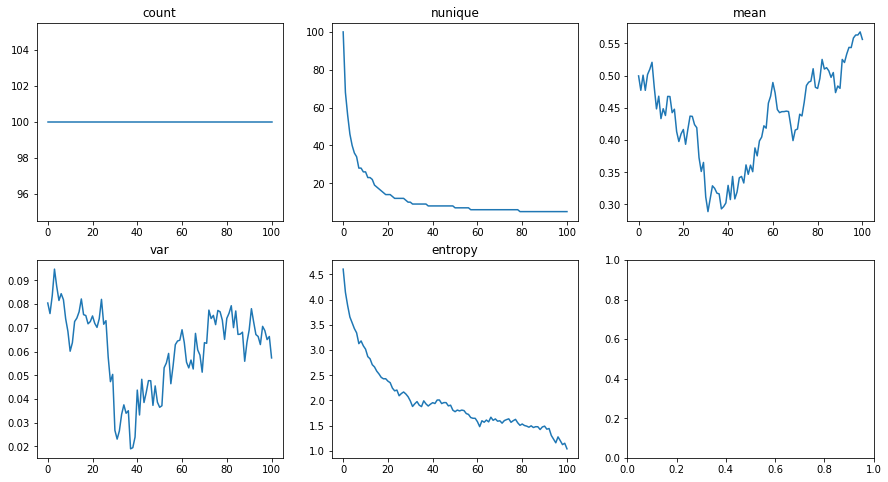

In [365]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3)
axes_flat = [ax for row in axes for ax in row]
for c, ax in zip(summary.columns, axes_flat):
    summary[c].plot.line(figsize=(15, 8), title=c, ax=ax)

In [380]:
val, vec = np.linalg.eig(adj_dense_norm)
vec_list = [vec[:,i] for i in range(val.shape[0])]

In [383]:
val_vec_srt = sorted(zip(val, vec_list), key=lambda t: abs(t[0]), reverse=True)

In [388]:
val_vec_srt[1][1]

array([-0.08812425,  0.12235573,  0.10098565,  0.0275002 , -0.00350664,
        0.00924955, -0.07153997,  0.11959594, -0.0010308 ,  0.08043047,
        0.03237703,  0.03112116,  0.03319359, -0.11051126,  0.03114553,
       -0.23127715,  0.0614744 , -0.00593219, -0.23354602, -0.00172498,
       -0.06373848, -0.09012889, -0.05367352,  0.00089483, -0.06260489,
       -0.00218477,  0.13754864, -0.10912677, -0.00858614, -0.15090125,
       -0.12167464, -0.10189368, -0.0550934 ,  0.03709823,  0.01232858,
        0.08819516,  0.0374668 ,  0.047685  ,  0.02411848, -0.03826045,
       -0.02220255,  0.18149566,  0.09105453,  0.05646146, -0.07017483,
       -0.08039465, -0.02109196,  0.03052301, -0.04635398,  0.07935025,
       -0.06784479, -0.17812799,  0.11706448, -0.005467  ,  0.10001798,
       -0.01672743,  0.13424283, -0.09249142,  0.07958905, -0.03061149,
       -0.19998333,  0.0252166 ,  0.19116149, -0.21086986,  0.1435112 ,
       -0.03335121,  0.04758085, -0.04698988,  0.10242517, -0.14